# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
#Keeping all imports in one place
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline  
from tqdm import tqdm
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import random
import torch.optim as optim

In [2]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


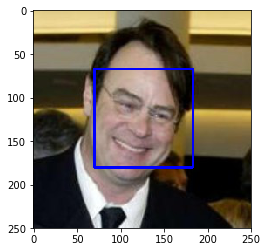

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

 - Detected human faces in the first 100 human faces : 98%
 - Detected dog faces in the first 100 dog faces : 17%


In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

In [6]:


#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
detected_faces_human = 0
detected_faces_dog = 0
for i in range(100):
    if(face_detector(human_files_short[i])):
        detected_faces_human += 1
    if(face_detector(dog_files_short[i])):
        detected_faces_dog += 1
        
print(f"Detected human faces: {detected_faces_human}%")
print(f"Detected dog faces: {detected_faces_dog}%")
    
        


Detected human faces: 98%
Detected dog faces: 17%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 96311872.65it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms
def image_to_tensor(img_path):
    img = Image.open(img_path).convert('RGB')
    transformations = transforms.Compose([transforms.Resize(224),
                                         transforms.CenterCrop((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
    image_tensor = transformations(img)[:3,:,:].unsqueeze(0)
    return image_tensor

In [9]:
def tensor_to_image(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0,1)
    return image

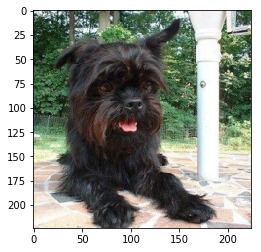

In [10]:

test_tensor = image_to_tensor('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')
#print(test_tensor)
#print(test_tensor.shape)
plt.imshow(tensor_to_image(test_tensor))

In [11]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img_tensor = image_to_tensor(img_path)
    if use_cuda:
        img_tensor = img_tensor.cuda()
    
    output = VGG16(img_tensor)
    _, preds_tensor = torch.max(output, 1)
    pred = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())
 
    return int(pred) # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [12]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    pred = VGG16_predict(img_path)
    
    
    return ((pred >= 151) & (pred <=268)) # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
 - Percentage of the images in human_files_short have a detected dog : 0%
 - Percentage of the images in dog_files_short have a detected dog : 100%

In [13]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

In [14]:

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
detected_dog_in_human = 0
detected_dog_in_dog = 0
for i in range(100):
    if(dog_detector(human_files_short[i])):
        detected_dog_in_human += 1
    if(dog_detector(dog_files_short[i])):
        detected_dog_in_dog += 1
        
print(f"percentage of the images in human_files_short have a detected dog: {detected_dog_in_human}%")
print(f"Percentage of the images in dog_files_short have a detected dog: {detected_dog_in_dog}%")

percentage of the images in human_files_short have a detected dog: 0%
Percentage of the images in dog_files_short have a detected dog: 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [14]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [15]:
import os
import torch
from torchvision import datasets,transforms

from PIL import ImageFile
#To fix the OSError: ImageFile is truncated (x bytes not processed)
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

transform = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop((224,224)),
                                transforms.RandomRotation(20),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.22])
                               ])

train_images = datasets.ImageFolder('/data/dog_images/train',transform)
test_images = datasets.ImageFolder('/data/dog_images/test',transform)
valid_images = datasets.ImageFolder('/data/dog_images/valid',transform)

loaders_scratch = {}
loaders_scratch['train'] = torch.utils.data.DataLoader(train_images,shuffle=True,batch_size=16,num_workers=2)
loaders_scratch['test'] = torch.utils.data.DataLoader(test_images,shuffle=True,batch_size=16,num_workers=2)
loaders_scratch['valid'] = torch.utils.data.DataLoader(valid_images,shuffle=True,batch_size=16,num_workers=2)

print((test_images))


Dataset ImageFolder
    Number of datapoints: 836
    Root Location: /data/dog_images/test
    Transforms (if any): Compose(
                             Resize(size=224, interpolation=PIL.Image.BILINEAR)
                             CenterCrop(size=(224, 224))
                             RandomRotation(degrees=(-20, 20), resample=False, expand=False)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.22])
                         )
    Target Transforms (if any): None


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
    Yes I have decided to augment the dataset. All the images in the dataset is sent to a pipeline which has 4 transformations.
 - All the images are first Center Cropped to 224*224 pixels.
 - Then, the images are Randomly Rotated at a degree of -20 to 20.
 - The next step is to Randomly Flip the images horizontally with the probability of 0.5 and converted to a tensor
 - The pixel values in the images are normalized.
 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,padding=1)
        
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*28*28,512)
        self.fc2 = nn.Linear(512,133)
        self.dropout = nn.Dropout(0.25)
        self.dropout1 = nn.Dropout(0.4)
        
    
    def forward(self, x):
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x))) #(16,112,112)
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x))) #(32,56,56)
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x))) #(64,28,28)
        x = self.dropout(x)
        
        #flatten it
        x = x.view(x.size(0),-1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

print (model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
  (dropout1): Dropout(p=0.4)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__


    There are totally 3 sets of Convolutional Layers and 2 Linear Dense Layers. The shape of the Image tensor starts with (3,224,224) and ends with (133) classes.
   - First, a Convolutional layer of 3 filters is used and a padding of (1,1) because I don't want to change the h\*w of the image. (Size = 3,224,224)
   - Then this output is sent to MaxPooling of standard 2\*2 size which reduced the h\*w of the image by a factor of 2.(Size = 3,112,112)
   - And then ReLu activation is used at the end to nullify the negative values.
   - And a dropout layer of p=0.25 is introduced to generalize the learning.
   - This batch of layers is repeated again twice with increased number of filters so that the model will be able to identify complex patterns and features.[Size = (16,112,112) -> (32,56,56) -> (64,28,28)]
   - Now, the input is flattened and is fed up to a couple of linear Dense layers to generalize the learning using the insights provided by the CNNs before and classify accordingly. [Size = (64,28,28) -> (50176) -> (512)->(133)]
    


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [28]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(),lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [29]:
import numpy as np
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 

    if os.path.exists(save_path):
        model.load_state_dict(torch.load(save_path))
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in loaders['train']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in loaders['valid']:
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output,target)
            valid_loss += loss.item()*data.size(0)

            
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased from {:.6f} to {:.6f}'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(),save_path)
            valid_loss_min = valid_loss
            
            
    # return trained model
    return model




In [30]:
# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')



Epoch: 1 	Training Loss: 4.631732 	Validation Loss: 4.655508
Validation loss decreased from inf to 4.655508
Epoch: 2 	Training Loss: 4.535319 	Validation Loss: 4.578033
Validation loss decreased from 4.655508 to 4.578033
Epoch: 3 	Training Loss: 4.395298 	Validation Loss: 4.464189
Validation loss decreased from 4.578033 to 4.464189
Epoch: 4 	Training Loss: 4.279064 	Validation Loss: 4.349780
Validation loss decreased from 4.464189 to 4.349780
Epoch: 5 	Training Loss: 4.203829 	Validation Loss: 4.319972
Validation loss decreased from 4.349780 to 4.319972
Epoch: 6 	Training Loss: 4.144556 	Validation Loss: 4.288721
Validation loss decreased from 4.319972 to 4.288721
Epoch: 7 	Training Loss: 4.077463 	Validation Loss: 4.311984
Epoch: 8 	Training Loss: 4.022141 	Validation Loss: 4.197625
Validation loss decreased from 4.288721 to 4.197625
Epoch: 9 	Training Loss: 3.955288 	Validation Loss: 4.186191
Validation loss decreased from 4.197625 to 4.186191
Epoch: 10 	Training Loss: 3.881332 	Vali

In [33]:
# train the model
model_scratch = train(10, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 2.410036 	Validation Loss: 4.042581
Validation loss decreased from inf to 4.042581
Epoch: 2 	Training Loss: 2.301752 	Validation Loss: 4.098136
Epoch: 3 	Training Loss: 2.233891 	Validation Loss: 4.162312
Epoch: 4 	Training Loss: 2.123294 	Validation Loss: 4.121551
Epoch: 5 	Training Loss: 2.052945 	Validation Loss: 4.228056
Epoch: 6 	Training Loss: 1.923647 	Validation Loss: 4.293503
Epoch: 7 	Training Loss: 1.862595 	Validation Loss: 4.290664
Epoch: 8 	Training Loss: 1.742896 	Validation Loss: 4.402619
Epoch: 9 	Training Loss: 1.656421 	Validation Loss: 4.476273
Epoch: 10 	Training Loss: 1.614014 	Validation Loss: 4.383268


In [25]:
# load the model that got the best validation accuracy


In [26]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [34]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.451409


Test Accuracy: 11% (97/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [19]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [20]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

model_transfer = models.resnet34(pretrained=True)
print (model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [21]:
for params in model_transfer.parameters():
    params.requires_grad = False
model_transfer.fc = nn.Linear(512,133)
if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

Transfer Learning is best suited for these types of classification problems since it has been already trained with large datasets and we can use this learnings to classify any objects. To achieve this, we have to tweak the last Linear layer of the model by training the model and updating the weights based on our datasets. Such models can be used as a features detectors (like Style Transfer) and also as Classifiers. ResNet34 model architecture is chosen for creating this Dog breed classifier. 


Since the ResNet34 is trained on dataset of 1000 classes , it won't work properly on our dataset which has only 133 classes. So the features weights are freezed and the last Linear layer (fc) -> Size(512,1000) is changed to Size(512,133). Finally, the model is trained for 20 epochs with CrossEntropyLoss which include LogSoftmax and NLLLoss. The resultant model gives an accuracy of 82%.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [22]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(),0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [23]:
# train the model
model_transfer = train(20, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.742425 	Validation Loss: 2.461511
Validation loss decreased from inf to 2.461511
Epoch: 2 	Training Loss: 2.149475 	Validation Loss: 1.550488
Validation loss decreased from 2.461511 to 1.550488
Epoch: 3 	Training Loss: 1.511441 	Validation Loss: 1.183029
Validation loss decreased from 1.550488 to 1.183029
Epoch: 4 	Training Loss: 1.210997 	Validation Loss: 1.014474
Validation loss decreased from 1.183029 to 1.014474
Epoch: 5 	Training Loss: 1.037898 	Validation Loss: 0.893604
Validation loss decreased from 1.014474 to 0.893604
Epoch: 6 	Training Loss: 0.910788 	Validation Loss: 0.813552
Validation loss decreased from 0.893604 to 0.813552
Epoch: 7 	Training Loss: 0.851437 	Validation Loss: 0.795702
Validation loss decreased from 0.813552 to 0.795702
Epoch: 8 	Training Loss: 0.785612 	Validation Loss: 0.755588
Validation loss decreased from 0.795702 to 0.755588
Epoch: 9 	Training Loss: 0.733154 	Validation Loss: 0.693955
Validation loss decreased from 0.755588 

In [24]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
print (model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [27]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.580738


Test Accuracy: 82% (691/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [29]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
is_cuda = torch.cuda.is_available()
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_images.classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    image_tensor = image_to_tensor(img_path)
    if is_cuda:
        image_tensor = image_tensor.cuda()
    output = model_transfer(image_tensor)
    _,pred_tensor = torch.max(output,1)
    pred = np.squeeze(pred_tensor.numpy()) if not use_cuda else np.squeeze(pred_tensor.cpu().numpy())
    return class_names[pred]

In [30]:
def show_image(img_path,title=""):
    img = Image.open(img_path)
    plt.title(title)
    plt.imshow(img)
    plt.show()

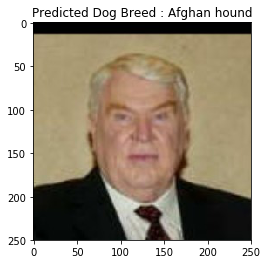

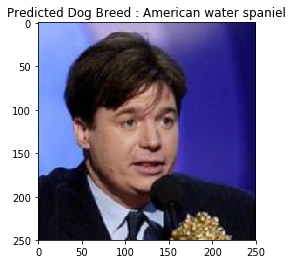

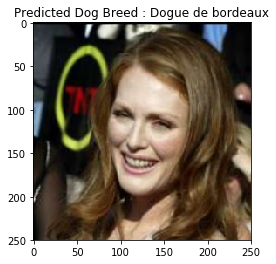

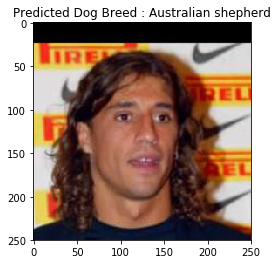

In [31]:
import random
for image in random.sample(list(human_files_short), 4):
    
    predicted_dog_breed = predict_breed_transfer(image)
    show_image(image,f"Predicted Dog Breed : {predicted_dog_breed}")

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [33]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    if face_detector(img_path):
        print("hello, human!")
        show_image(img_path)
        print("You look like a ...")
        print(predict_breed_transfer(img_path))
    elif dog_detector(img_path):
        print("Hey Dog!")
        predicted_dog_breed = predict_breed_transfer(img_path)
        show_image(img_path,f"Predicted Dog Breed : {predicted_dog_breed}")
    else:
        print("[ERR] Sorry couldn't recognize neither a face or dog in the image!")
        show_image(img_path,"???")
    
    print("\n")
        


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
- Deploy this model in a Flask app and expose the classifier as an API.
- Fine tune the model for an improved accuracy.
- Refactor the existing code
- When the dog breed classifier return two classes with max prob like (51%,47%,...) , our app should print both the breeds.-

hello, human!


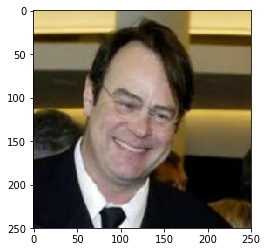

You look like a ...
Saint bernard


hello, human!


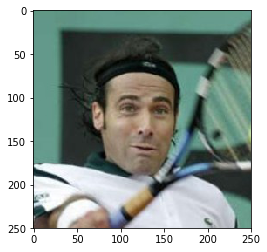

You look like a ...
Brittany


hello, human!


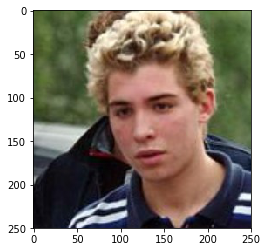

You look like a ...
Portuguese water dog


Hey Dog!


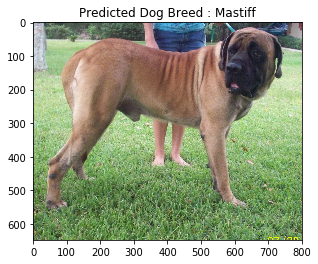



Hey Dog!


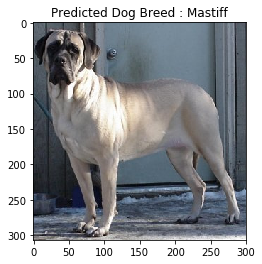



Hey Dog!


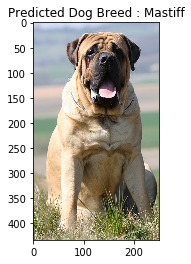

In [34]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)